# Partial state tomography

In this tutorial we look at the convergence of partial state tomography, and how this can be optimized by grouping.

1. An example algorithm
1. Sampling noise convergence
1. Calculating and propagating error bounds on sampling noise
1. Setting up parallel measurements

In [0]:
import cirq
import sympy
import openfermioncirq
from openfermion import MolecularData, jordan_wigner, eigenspectrum
import numpy as np

# An example algorithm

Let's take our VQE for the H2 molecule from last week; here's a simplified form.
First, code for the Hamiltonian:

In [0]:
diatomic_bond_length = .7414

geometry = [('H', (0., 0., 0.)), 
            ('H', (0., 0., diatomic_bond_length))]

basis = 'sto-3g'
multiplicity = 1
charge = 0
description = format(diatomic_bond_length)

molecule = MolecularData(
    geometry,
    basis,
    multiplicity,
    description=description)
molecule.load()

hamiltonian = jordan_wigner(molecule.get_molecular_hamiltonian())

In [0]:
theta = sympy.Symbol('theta')
qubits = [cirq.GridQubit(i,j) for i in range(2) for j in range(2)]

class H2Ansatz(openfermioncirq.VariationalAnsatz):
    
    def params(self):
        return [theta]

    def operations(self, qubits):
        yield [cirq.ry(np.pi).on(qubits[0]),
               cirq.ry(np.pi).on(qubits[1])]
        yield [cirq.rx(np.pi/2).on(qubits[0]),
               cirq.ry(np.pi/2).on(qubits[1]),
               cirq.ry(np.pi/2).on(qubits[2]),
               cirq.ry(np.pi/2).on(qubits[3])]
        yield [cirq.CNOT(qubits[0], qubits[1]),
               cirq.CNOT(qubits[1], qubits[2]),
               cirq.CNOT(qubits[2], qubits[3])]
        yield cirq.rz(theta).on(qubits[3])
        yield [cirq.CNOT(qubits[2], qubits[3]),
               cirq.CNOT(qubits[1], qubits[2]),
               cirq.CNOT(qubits[0], qubits[1])]
        yield [cirq.rx(-np.pi/2).on(qubits[0]),
               cirq.ry(-np.pi/2).on(qubits[1]),
               cirq.ry(-np.pi/2).on(qubits[2]),
               cirq.ry(-np.pi/2).on(qubits[3])]
        
    def _generate_qubits(self):
        return qubits

ansatz = H2Ansatz()

objective = openfermioncirq.HamiltonianObjective(hamiltonian)
study = openfermioncirq.VariationalStudy(
    name='UCC_single_term',
    ansatz=ansatz,
    objective=objective)

print(study.circuit)

(0, 0): ───Ry(π)──────Rx(0.5π)───@───────────────────────────────────────@───────────Rx(-0.5π)───
                                 │                                       │
(0, 1): ───Ry(π)──────Ry(0.5π)───X───@───────────────────────@───────────X───────────Ry(-0.5π)───
                                     │                       │
(1, 0): ───Ry(0.5π)──────────────────X───@───────────────@───X───────────Ry(-0.5π)───────────────
                                         │               │
(1, 1): ───Ry(0.5π)──────────────────────X───Rz(theta)───X───Ry(-0.5π)───────────────────────────


Now, let's find the optimal angle choice for our ground state, and fix it in our VQE

In [0]:
from openfermioncirq.optimization import COBYLA, OptimizationParams
optimization_params = OptimizationParams(
    algorithm=COBYLA,
    initial_guess=[0.01])
result = study.optimize(optimization_params)
print('Optimized VQE result: {}'.format(result.optimal_value))
print('Target Hamiltonian eigenvalue: {}'.format(eigenspectrum(hamiltonian)[0]))
print('Optimal angle: {}'.format(result.optimal_parameters))

from cirq import ParamResolver, resolve_parameters
resolver = ParamResolver({'theta': result.optimal_parameters})
resolved_circuit = resolve_parameters(study.circuit, resolver)

print(resolved_circuit)

Optimized VQE result: -1.1372701737048119
Target Hamiltonian eigenvalue: -1.137270174625328
Optimal angle: [-0.22618398]
(0, 0): ───Ry(π)──────Rx(0.5π)───@─────────────────────────────────────────@───────────Rx(-0.5π)───
                                 │                                         │
(0, 1): ───Ry(π)──────Ry(0.5π)───X───@─────────────────────────@───────────X───────────Ry(-0.5π)───
                                     │                         │
(1, 0): ───Ry(0.5π)──────────────────X───@─────────────────@───X───────────Ry(-0.5π)───────────────
                                         │                 │
(1, 1): ───Ry(0.5π)──────────────────────X───Rz(-0.072π)───X───Ry(-0.5π)───────────────────────────


For the rest of the tutorial we'll just worry about this circuit, and in particular how we estimate the energy of the prepared state.

Let's start by investigating the Hamiltonian above a bit

In [0]:
hamiltonian

-0.09886397351781592 [] +
-0.04532220209856541 [X0 X1 Y2 Y3] +
0.04532220209856541 [X0 Y1 Y2 X3] +
0.04532220209856541 [Y0 X1 X2 Y3] +
-0.04532220209856541 [Y0 Y1 X2 X3] +
0.17119774853325856 [Z0] +
0.16862219143347554 [Z0 Z1] +
0.12054482186554413 [Z0 Z2] +
0.16586702396410954 [Z0 Z3] +
0.17119774853325856 [Z1] +
0.16586702396410954 [Z1 Z2] +
0.12054482186554413 [Z1 Z3] +
-0.22278592890107016 [Z2] +
0.17434844170557132 [Z2 Z3] +
-0.22278592890107016 [Z3]

In order to estimate $\langle \Psi|H|\Psi\rangle$, we want to split it into the different terms as above, and sum the expectation values of the individual terms.

Let's first take a single term - $Z_0$:

**Problem 1:** Extract the wavefunction generated by the above circuit acting on $|0000\rangle$, and calculate the expectation value of $Z_0$.

In [0]:
from openfermion.utils import count_qubits

In [0]:
# Let's take the number of qubits
num_qubits = count_qubits(hamiltonian)
# Import the Simulator class from cirq
simulator = cirq.Simulator()
# Our initial state in vector form is [1,0,0,0...]
init_state = np.zeros(2**num_qubits)
init_state[0]=1.0

In [0]:
# Simulate the resolved circuit with |0000> as starting state
simulated_circuit = simulator.simulate(resolved_circuit, initial_state=init_state)

In [0]:
print('The wavefunction of the resolved circuit is: ', simulated_circuit.dirac_notation())

The wavefunction of the resolved circuit is:  -0.11|0011⟩ + 0.99|1100⟩


In [0]:
print('The wavefunction of the resolved circuit is: \n', simulated_circuit.final_state.round(4))

The wavefunction of the resolved circuit is: 
 [ 0.    +0.j  0.    +0.j  0.    +0.j -0.1129+0.j  0.    +0.j  0.    +0.j
  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j
  0.9936+0.j  0.    +0.j  0.    +0.j  0.    +0.j]


In [0]:
from openfermion import QubitOperator, expectation, get_sparse_operator

In [0]:
# Next we compute the expectation value of Z0
# Get the sparse matrix of the Z0 operator, with the correct weight and number of qubits
Z0op = get_sparse_operator(QubitOperator('Z0', 1.0), n_qubits=num_qubits)

In [0]:
# Openfermion has a function that computes expectation values from matrices.
Z0_expectation = expectation(Z0op, simulated_circuit.final_state)
# This function does the same as:
Z0_expectation_mat = np.conj(simulated_circuit.final_state) @ Z0op @ simulated_circuit.final_state

In [0]:
print('The expectation value of Z0 is: ', Z0_expectation)
print('or from matrix multiplication : ', Z0_expectation_mat)

The expectation value of Z0 is:  (-0.9745288369552503+0j)
or from matrix multiplication :  (-0.9745288369552503+0j)


Unfortunately, on a quantum computer we never have direct access to the wavefunction. Instead, we have to estimate $\langle\Psi|Z_0|\Psi\rangle$ by inference from repeated preparation of $|\Psi\rangle$ and measurement in the $Z_0$ basis.

**Problem 2:** Copy the resolved circuit, and add a measurement of qubit $0$ in the $Z$ basis.

In [0]:
new_circuit = cirq.Circuit(resolved_circuit)

In [0]:
new_circuit.append(cirq.measure(ansatz.qubits[0], key='z'))

In [0]:
print(new_circuit)

(0, 0): ───Ry(π)──────Rx(0.5π)───@─────────────────────────────────────────@───────────Rx(-0.5π)───M('z')───
                                 │                                         │
(0, 1): ───Ry(π)──────Ry(0.5π)───X───@─────────────────────────@───────────X───────────Ry(-0.5π)────────────
                                     │                         │
(1, 0): ───Ry(0.5π)──────────────────X───@─────────────────@───X───────────Ry(-0.5π)────────────────────────
                                         │                 │
(1, 1): ───Ry(0.5π)──────────────────────X───Rz(-0.072π)───X───Ry(-0.5π)────────────────────────────────────


**Problem 3:** Extract an estimation of $\langle\Psi|Z_0|\Psi\rangle$ from the output of $10^4$ repetitions of the above circuit, and compare to your answer to Problem 1.

In [0]:
def probability_to_expectation(probability, out):
    if out==0:
        return 2*probability - 1
    else:
        return 1-2*probability

In [0]:
sampled_circuit = simulator.run(new_circuit, repetitions=10**4)
prob1 = sampled_circuit.histogram(key='z')[1]/10**4
Z0_reps = probability_to_expectation(prob1,1)

In [0]:
print('The expectation value of Z0 from 10^4 samples is: ',Z0_reps)

The expectation value of Z0 from 10^4 samples is:  -0.9762


In [0]:
print('The error with respect to the infinite sampling is: ', np.abs(Z0_reps - Z0_expectation))

The error with respect to the infinite sampling is:  0.0016711630447496795


This works, but it's not perfect, is it? The result can be improved by turning up the number of repetitions, let's try it:

**Problem 4:** Repeat the above using $100$, $500$, $1000$, $5000$, and $10^4$ repetitions. For each choice of the number of repetitions, average the error in your approximation over $10$ experiments.

In [1]:
shot_list = [10, 50, 100, 500, 1000, 5000, 10000]
experiments = {}
for shots in shot_list:
    aux = []
    for _ in range(10):
        sampled_circuit = simulator.run(new_circuit, repetitions=shots)
        prob1 = sampled_circuit.histogram(key='z')[1]/shots
        aux.append(np.abs(probability_to_expectation(prob1,1) - Z0_expectation))
    experiments.update({shots: np.average(aux)})

NameError: ignored

**Problem 5:** Create a log-log plot of the above results and determine the scaling of the error as a function of the number of repetitions

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
#Plotting parameters

plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'Times'
#plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['figure.figsize'] = (80, 50)
plt.rcParams['figure.dpi'] = 50
plt.rcParams['font.size'] = 45
plt.rcParams['axes.linewidth'] = 15.0
plt.rcParams['axes.labelsize'] = 210
plt.rcParams['axes.titlesize'] = 60
plt.rcParams['legend.fontsize'] = 80
plt.rcParams['lines.linewidth'] = 20
plt.rcParams['lines.markersize'] = 60
#plt.rcParams['lines.markeredgewidth'] = 25

plt.rcParams['xtick.labelsize'] = 150
plt.rcParams['ytick.labelsize'] = 150
plt.rcParams['xtick.major.size'] = 110.0
plt.rcParams['xtick.major.width'] = 15.0
plt.rcParams['xtick.major.pad'] = 80.0
plt.rcParams['xtick.minor.size'] = 70.0
plt.rcParams['xtick.minor.width'] = 12.0
plt.rcParams['ytick.major.size'] = 110.0
plt.rcParams['ytick.major.width'] = 15.0
plt.rcParams['ytick.minor.size'] = 70.0
plt.rcParams['ytick.minor.width'] = 12.0
plt.rcParams['ytick.major.pad'] = 40.0

#plt.rcParams['text.usetex'] = True
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.edgecolor"] = "w"

In [0]:
y = np.array(list(experiments.values()))
x = np.log10(np.array(shot_list))

In [0]:
curve_fit = np.polyfit(x, y, 1)

In [0]:
y_data = curve_fit[0] * x + curve_fit[1]

In [0]:
curve_fit

array([-0.0199226 ,  0.07035223])

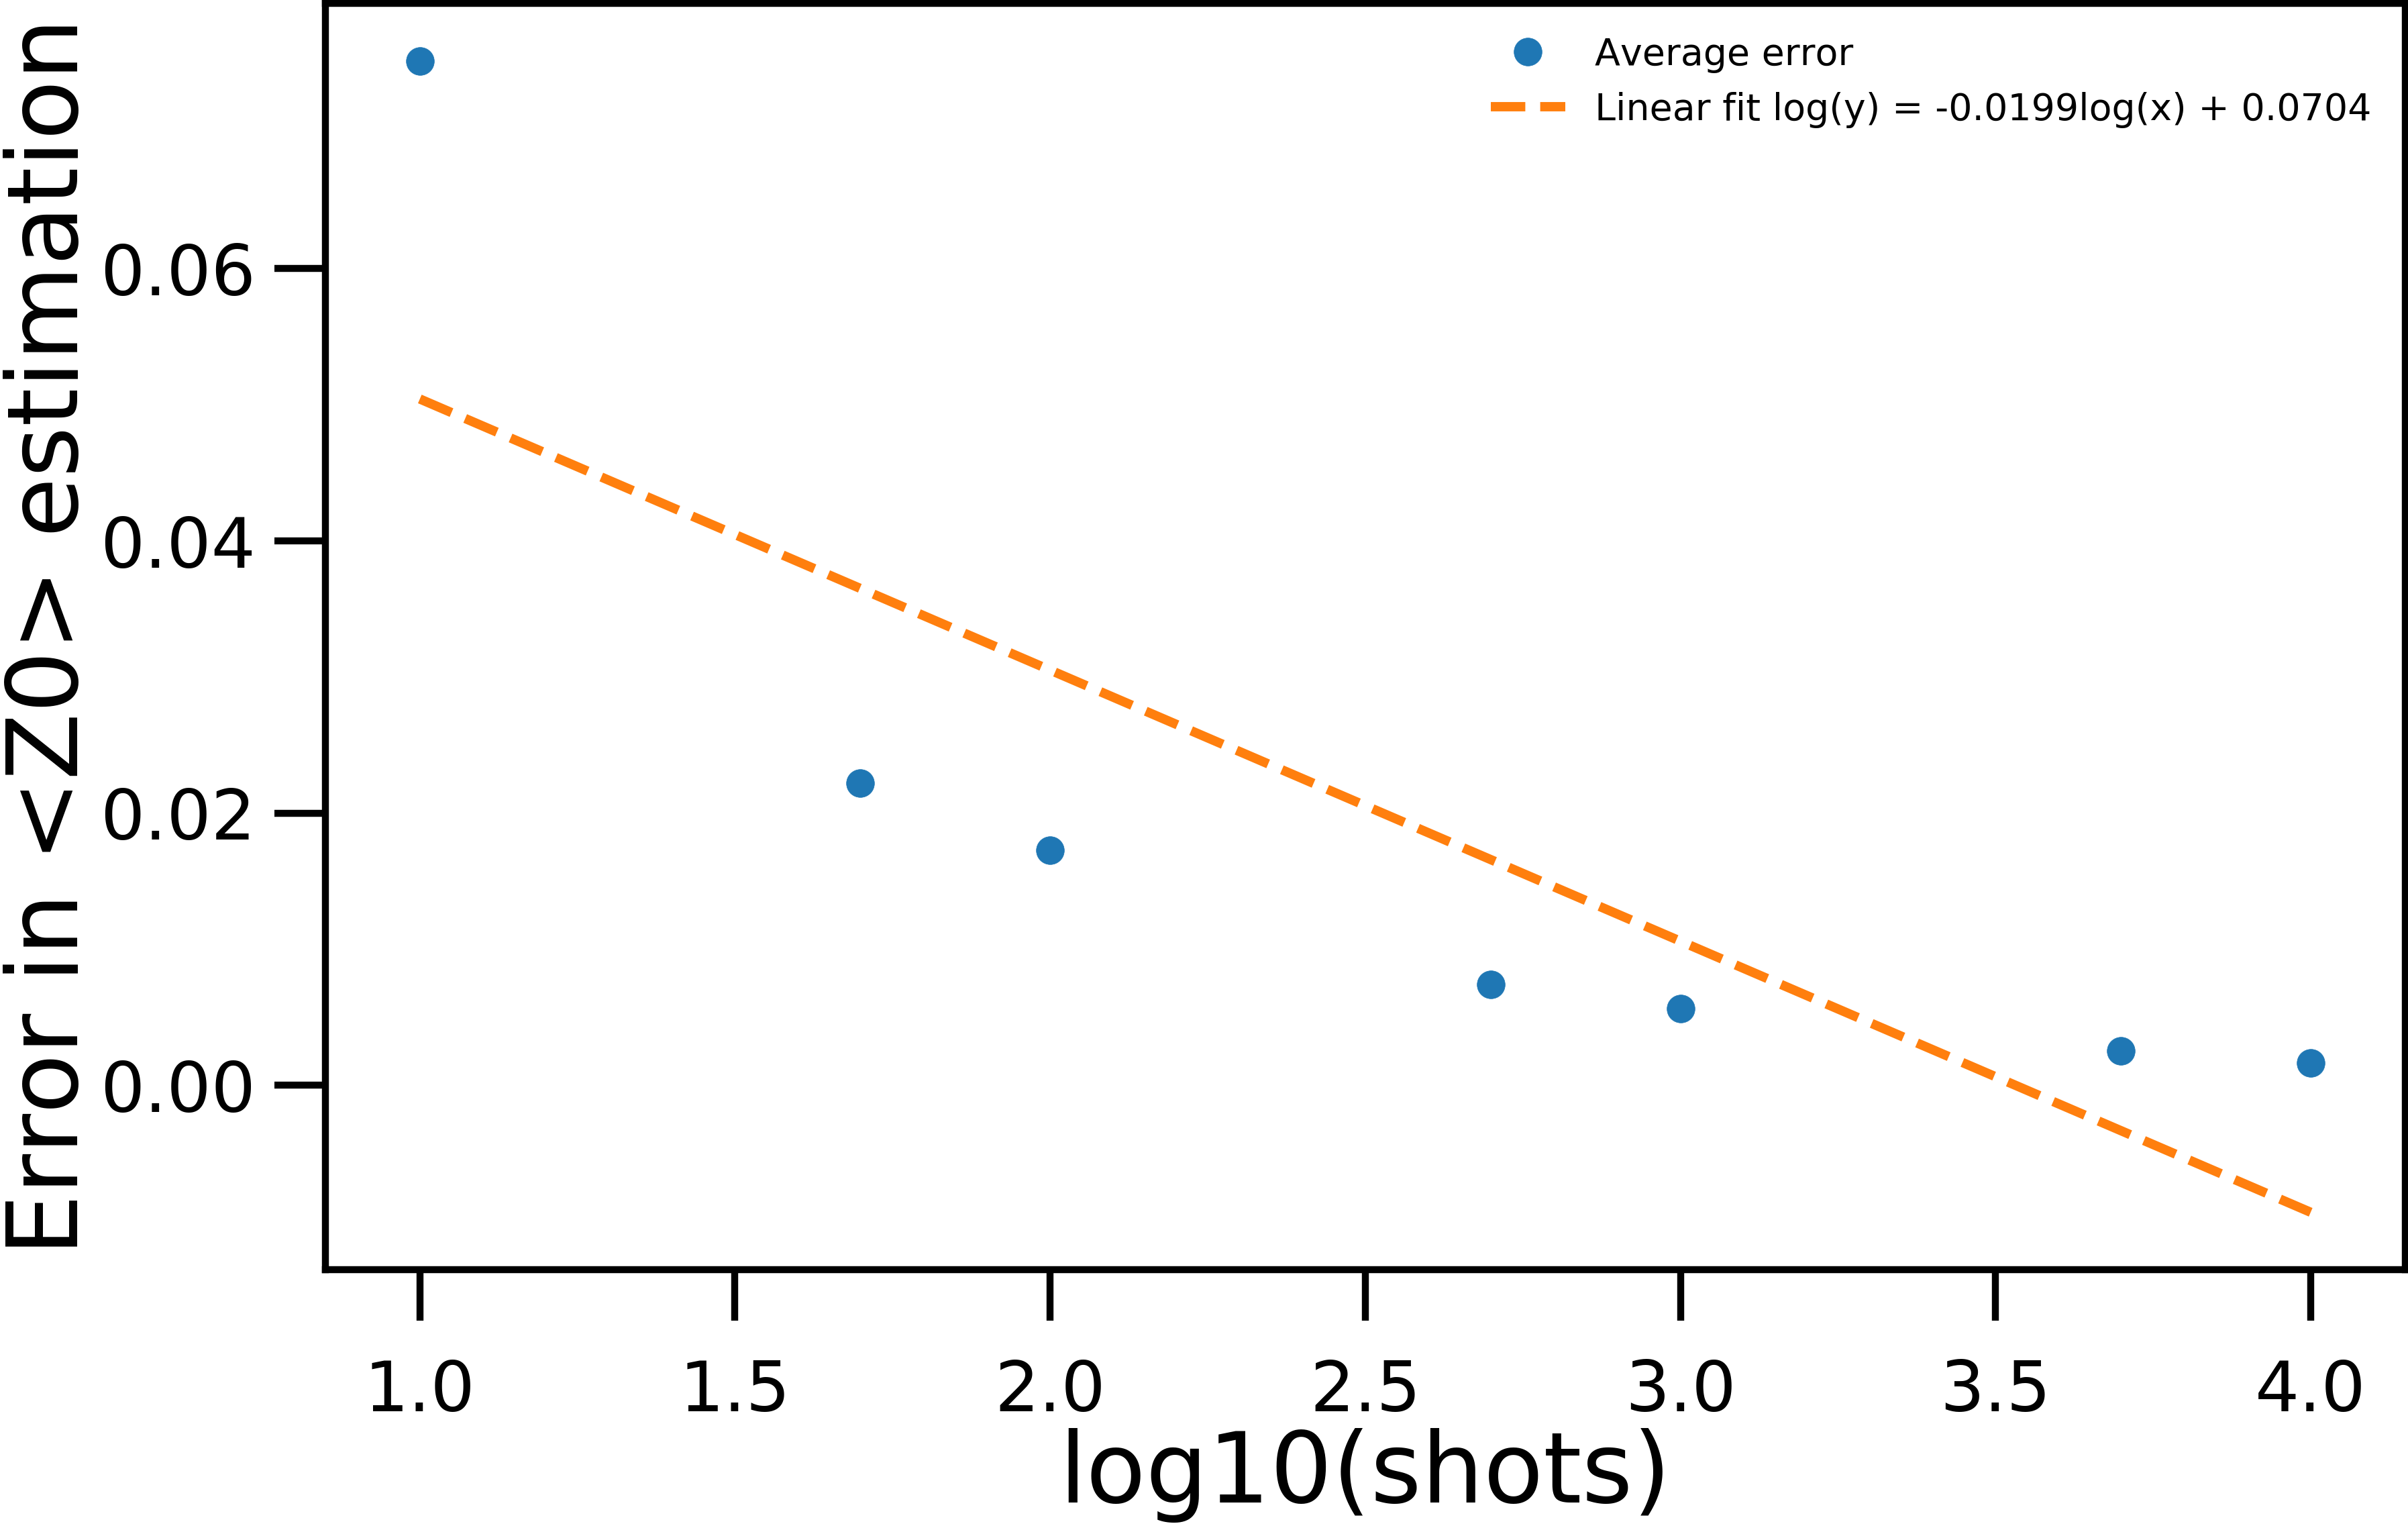

In [0]:
#plt.figure(figsize=(15, 10))
plt.plot(x, np.array(list(experiments.values())), 'o', label='Average error')
plt.plot(x, y_data, '--', label='Linear fit log(y) = {}log(x) + {}'.format(curve_fit[0].round(4),
                                                                           curve_fit[1].round(4)))
plt.xlabel('log10(shots)')
plt.ylabel('Error in <Z0> estimation')

plt.legend(frameon=False)

In [0]:
print('The error in estimation scales as: ',np.abs(curve_fit[0]))

The error in estimation scales as:  0.01992260247681999


In [0]:
print('The inverse of the number of shots is: ', 1/np.sqrt(shot_list[-1]))

The inverse of the number of shots is:  0.01


This scaling is called sampling noise scaling, and is fundamental to any quantum device. In particular, this implies that extracting any expectation value to exponentially small precision is generally exponentially difficult (though exceptions do exist). Luckily, we can still achieve a speedup over classical computers with only polynomially small error.

This circuitry above works for the single operator we focused on, but we need to get the rest. Luckily, we can parallelise this significantly. In particular, all products of $Z$ operators are amenable --- they share the same tensor factors on each qubit --- and can be read out simultaneously in a single experiment.

**Problem 6**: write code to estimate expectation values for all tensor products of $Z$ operators in the above Hamiltonian using the output from a single circuit, and execute it using $10^4$ shots.

In [0]:
labels = ['Z'+str(i) for i in range(num_qubits)]
new_circuit_Z=cirq.Circuit(resolved_circuit)
new_circuit_Z.append(cirq.measure(q, key=labels[i]) for i,q in enumerate(ansatz.qubits))

In [0]:
print(new_circuit_Z)

(0, 0): ───Ry(π)──────Rx(0.5π)───@─────────────────────────────────────────@───────────Rx(-0.5π)───M('Z0')───
                                 │                                         │
(0, 1): ───Ry(π)──────Ry(0.5π)───X───@─────────────────────────@───────────X───────────Ry(-0.5π)───M('Z1')───
                                     │                         │
(1, 0): ───Ry(0.5π)──────────────────X───@─────────────────@───X───────────Ry(-0.5π)───M('Z2')───────────────
                                         │                 │
(1, 1): ───Ry(0.5π)──────────────────────X───Rz(-0.072π)───X───Ry(-0.5π)───M('Z3')───────────────────────────


In [0]:
circuit_shots = simulator.run(new_circuit_Z, repetitions=10**4)

In [0]:
import itertools
qop_expcts = QubitOperator()
for lb in labels:
    prob = circuit_shots.multi_measurement_histogram(keys=[lb])[(1,)]/10**4
    expct = probability_to_expectation(prob, out=1)
    qop_expcts+=QubitOperator(lb, expct)
print(qop_expcts)

-0.9743999999999999 [Z0] +
-0.9743999999999999 [Z1] +
0.9744 [Z2] +
0.9744 [Z3]


In [0]:
for comb in itertools.combinations(labels, 2):
    prob1 = (circuit_shots.multi_measurement_histogram(keys=comb)[(0,1)] +
             circuit_shots.multi_measurement_histogram(keys=comb)[(1,0)])/10**4
    prob0 = 1 - prob1
    expct = probability_to_expectation(prob1, out=1)
    qop_expcts+=QubitOperator(' '.join(comb), expct)
print(qop_expcts)
#print()

-0.9743999999999999 [Z0] +
1.0 [Z0 Z1] +
-1.0 [Z0 Z2] +
-1.0 [Z0 Z3] +
-0.9743999999999999 [Z1] +
-1.0 [Z1 Z2] +
-1.0 [Z1 Z3] +
0.9744 [Z2] +
1.0 [Z2 Z3] +
0.9744 [Z3]


This leaves four expectation values to calculate. Unfortunately none of the corresponding operators are amenable, and so the expectation values cannot be estimated simultaneously with single-qubit rotations. The simplest (and lowest-depth) method to estimate the remaining four expectation values is in parallel.

**Problem 7**: write circuits and code to estimate the expectation values of the remaining four operators, and evaluate this using $10^4$ repetitions.

In [0]:
labels = ['X0', 'X1', 'Y2', 'Y3']
new_circuit_xxyy =cirq.Circuit(resolved_circuit)
new_circuit_xxyy.append(cirq.ry(-np.pi/2).on(ansatz.qubits[3]))
new_circuit_xxyy.append(cirq.ry(-np.pi/2).on(ansatz.qubits[2]))
new_circuit_xxyy.append(cirq.rx(np.pi/2).on(ansatz.qubits[1]))
new_circuit_xxyy.append(cirq.rx(np.pi/2).on(ansatz.qubits[0]))
new_circuit_xxyy.append(cirq.measure(q, key=labels[i]) for i,q in enumerate(ansatz.qubits))

#print(new_circuit_xxyy)
circuit_shots = simulator.run(new_circuit_xxyy, repetitions=10**4)
prob0 = (circuit_shots.multi_measurement_histogram(keys=labels)[(0,0,1,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,1,0,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,1,1,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,0,1,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,0,0,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,1,0,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,0,0,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,1,1,1)])/10**4
prob1 = 1 - prob0
expct = probability_to_expectation(prob1, out=1)
qop_expcts+=QubitOperator(' '.join(labels), expct)
print(qop_expcts)

0.21320000000000006 [X0 X1 Y2 Y3] +
-0.9743999999999999 [Z0] +
1.0 [Z0 Z1] +
-1.0 [Z0 Z2] +
-1.0 [Z0 Z3] +
-0.9743999999999999 [Z1] +
-1.0 [Z1 Z2] +
-1.0 [Z1 Z3] +
0.9744 [Z2] +
1.0 [Z2 Z3] +
0.9744 [Z3]


In [0]:
labels = ['X0', 'Y1', 'Y2', 'X3']
new_circuit_xyyx =cirq.Circuit(resolved_circuit)
new_circuit_xyyx.append(cirq.ry(-np.pi/2).on(ansatz.qubits[0]))
new_circuit_xyyx.append(cirq.rx(np.pi/2).on(ansatz.qubits[1]))
new_circuit_xyyx.append(cirq.rx(np.pi/2).on(ansatz.qubits[2]))
new_circuit_xyyx.append(cirq.ry(-np.pi/2).on(ansatz.qubits[3]))
new_circuit_xyyx.append(cirq.measure(q, key=labels[i]) for i,q in enumerate(ansatz.qubits))

circuit_shots = simulator.run(new_circuit_xyyx, repetitions=10**4)
prob0 = (circuit_shots.multi_measurement_histogram(keys=labels)[(0,0,1,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,1,0,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,1,1,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,0,1,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,0,0,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,1,0,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,0,0,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,1,1,1)])/10**4
prob1 = 1 - prob0
expct = probability_to_expectation(prob1, out=1)
qop_expcts+=QubitOperator(' '.join(labels), expct)
print(qop_expcts)

0.21320000000000006 [X0 X1 Y2 Y3] +
-0.21399999999999997 [X0 Y1 Y2 X3] +
-0.9743999999999999 [Z0] +
1.0 [Z0 Z1] +
-1.0 [Z0 Z2] +
-1.0 [Z0 Z3] +
-0.9743999999999999 [Z1] +
-1.0 [Z1 Z2] +
-1.0 [Z1 Z3] +
0.9744 [Z2] +
1.0 [Z2 Z3] +
0.9744 [Z3]


In [0]:
labels = ['Y0', 'X1', 'X2', 'Y3']
new_circuit_yxxy =cirq.Circuit(resolved_circuit)
new_circuit_yxxy.append(cirq.rx(np.pi/2).on(ansatz.qubits[0]))
new_circuit_yxxy.append(cirq.ry(-np.pi/2).on(ansatz.qubits[1]))
new_circuit_yxxy.append(cirq.ry(-np.pi/2).on(ansatz.qubits[2]))
new_circuit_yxxy.append(cirq.rx(np.pi/2).on(ansatz.qubits[3]))
new_circuit_yxxy.append(cirq.measure(q, key=labels[i]) for i,q in enumerate(ansatz.qubits))

circuit_shots = simulator.run(new_circuit_yxxy, repetitions=10**4)
prob0 = (circuit_shots.multi_measurement_histogram(keys=labels)[(0,0,1,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,1,0,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,1,1,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,0,1,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,0,0,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,1,0,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,0,0,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,1,1,1)])/10**4
prob1 = 1 - prob0
expct = probability_to_expectation(prob1, out=1)
qop_expcts+=QubitOperator(' '.join(labels), expct)
print(qop_expcts)

0.21320000000000006 [X0 X1 Y2 Y3] +
-0.21399999999999997 [X0 Y1 Y2 X3] +
-0.20100000000000007 [Y0 X1 X2 Y3] +
-0.9743999999999999 [Z0] +
1.0 [Z0 Z1] +
-1.0 [Z0 Z2] +
-1.0 [Z0 Z3] +
-0.9743999999999999 [Z1] +
-1.0 [Z1 Z2] +
-1.0 [Z1 Z3] +
0.9744 [Z2] +
1.0 [Z2 Z3] +
0.9744 [Z3]


In [0]:
labels = ['Y0', 'Y1', 'X2', 'X3']
new_circuit_yyxx =cirq.Circuit(resolved_circuit)
new_circuit_yyxx.append(cirq.rx(np.pi/2).on(ansatz.qubits[0]))
new_circuit_yyxx.append(cirq.rx(np.pi/2).on(ansatz.qubits[1]))
new_circuit_yyxx.append(cirq.ry(-np.pi/2).on(ansatz.qubits[2]))
new_circuit_yyxx.append(cirq.ry(-np.pi/2).on(ansatz.qubits[3]))
new_circuit_yyxx.append(cirq.measure(q, key=labels[i]) for i,q in enumerate(ansatz.qubits))

circuit_shots = simulator.run(new_circuit_yyxx, repetitions=10**4)
prob0 = (circuit_shots.multi_measurement_histogram(keys=labels)[(0,0,1,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,1,0,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,1,1,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,0,1,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,0,0,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,1,0,1)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(0,0,0,0)] +
         circuit_shots.multi_measurement_histogram(keys=labels)[(1,1,1,1)])/10**4
prob1 = 1 - prob0
expct = probability_to_expectation(prob1, out=1)
qop_expcts+=QubitOperator(' '.join(labels), expct)
print(qop_expcts)

0.21320000000000006 [X0 X1 Y2 Y3] +
-0.21399999999999997 [X0 Y1 Y2 X3] +
-0.20100000000000007 [Y0 X1 X2 Y3] +
0.22120000000000006 [Y0 Y1 X2 X3] +
-0.9743999999999999 [Z0] +
1.0 [Z0 Z1] +
-1.0 [Z0 Z2] +
-1.0 [Z0 Z3] +
-0.9743999999999999 [Z1] +
-1.0 [Z1 Z2] +
-1.0 [Z1 Z3] +
0.9744 [Z2] +
1.0 [Z2 Z3] +
0.9744 [Z3]


In [0]:
# We need to add the Identity which is always guaranteed to be 1.0
qop_expcts+= QubitOperator(' ',1.0)
print('The expectation values as a qubitoperator: \n', qop_expcts)

The expectation values as a qubitoperator: 
 1.0 [] +
0.21320000000000006 [X0 X1 Y2 Y3] +
-0.21399999999999997 [X0 Y1 Y2 X3] +
-0.20100000000000007 [Y0 X1 X2 Y3] +
0.22120000000000006 [Y0 Y1 X2 X3] +
-0.9743999999999999 [Z0] +
1.0 [Z0 Z1] +
-1.0 [Z0 Z2] +
-1.0 [Z0 Z3] +
-0.9743999999999999 [Z1] +
-1.0 [Z1 Z2] +
-1.0 [Z1 Z3] +
0.9744 [Z2] +
1.0 [Z2 Z3] +
0.9744 [Z3]


It remains to combine the values that you have to estimate the expectation value of the Hamiltonian itself.

**Problem 8:** Take an appropriate linear combination of the values calculated above to estimate the expectation value of the Hamiltonian, and compare to the value originally found.

In [0]:
qop_result = hamiltonian * qop_expcts
print('Sampled energy: ', qop_result.terms[()])
print('Exact energy  : ', molecule.fci_energy)

Sampled energy:  -1.1350091010846177
Exact energy  :  -1.137270174625328


### Comparison to sampling from a distribution

Sampling expectation values of a Pauli operator approximate the normal distribution for sufficiently large number of measurements $\sim 100$.
We can check if this result is true by sampling from a normal distribution with $\mu = E_0$ and $\sigma =\frac{1}{\sqrt{M}}$

In [0]:
1/(4*np.sqrt(10**4))

0.0025

In [0]:
sampled_energies = np.random.normal(molecule.fci_energy, 4/(10**4), 100)

In [0]:
print('Some sampled energies: \n', sampled_energies)

Some sampled energies: 
 [-1.13713779 -1.13724898 -1.13729607 -1.13804733 -1.13707138 -1.1371988
 -1.13725444 -1.13663161 -1.13745129 -1.13736781 -1.13737449 -1.13752191
 -1.13682332 -1.1368158  -1.13713794 -1.13711353 -1.13711885 -1.13688437
 -1.13744496 -1.13686084 -1.1371939  -1.13753843 -1.13695325 -1.1379043
 -1.13739846 -1.13711638 -1.1369985  -1.13672492 -1.1376408  -1.13797387
 -1.13677282 -1.13713149 -1.13744319 -1.13732549 -1.13676392 -1.13704414
 -1.13718233 -1.1369885  -1.13713942 -1.13692665 -1.13749796 -1.13716354
 -1.1371069  -1.13750132 -1.13776742 -1.13727548 -1.13772677 -1.13660754
 -1.13645355 -1.13730628 -1.13671298 -1.13668178 -1.13732512 -1.13743708
 -1.13750149 -1.13678318 -1.13747617 -1.13769139 -1.13677544 -1.13709757
 -1.13730966 -1.13647179 -1.1360093  -1.13803832 -1.13749236 -1.13640283
 -1.13740661 -1.13692204 -1.1377863  -1.13738556 -1.13748227 -1.13699862
 -1.13678623 -1.13712222 -1.13773107 -1.13684909 -1.13828491 -1.13739023
 -1.13683895 -1.13740987 -1.

**Extension problem 1:** Write down analytic formulae for the expectation values of single Pauli operators, and use this to write a function to predict the error in the estimation of the Hamiltonian. Compare your results with simulation.

**Extension problem 2:** In the above, we chose a fixed number of samples for each estimation, regardless of how much this contributed to the final Hamiltonian. How could you optimize this choice?

**Extension problem 3:** Although amenability is sufficient for simultaneous measurement of operators, it is not necessary; the necessary condition is just that the operators commute. Which of the operators you studied in Problem 7 commute? Can you design a circuit to perform simultaneous measurement of them?